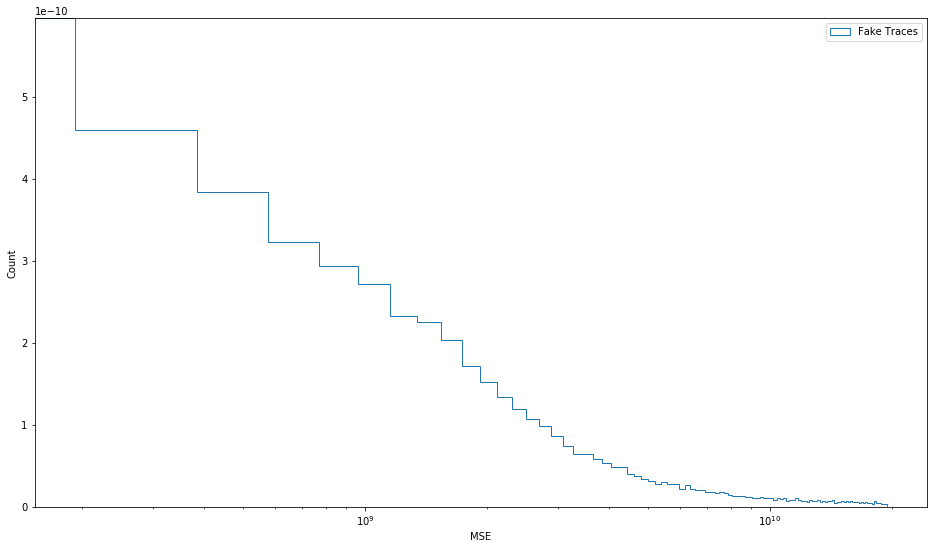

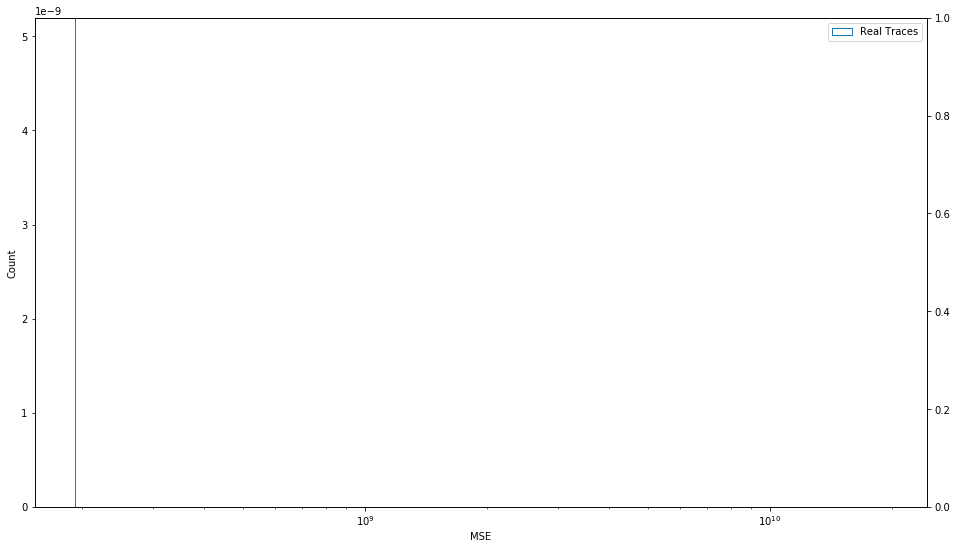

In [50]:
import matplotlib.pyplot as plt
import csv
import numpy as np
from sklearn.preprocessing import normalize


#Read in the data. 
trace = {'data':[],'target':[]}
with open("tracesummaries.csv") as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    traces = []
    for row in csv_reader:
        if line_count == 0:
            line_count += 1
        else:
            trace['data'].append([row[3],row[4],row[5],row[6]])
            trace['target'].append(int(row[7]))

x = np.asarray(trace['data']).astype(np.float)
y = np.asarray(trace['target']).astype(np.int)

mu_0 = np.mean(x[y==0])
mu_1 = np.mean(x[y==1])
sigma_0 = np.std(x[y==0])**2
sigma_1 = np.std(x[y==1])**2
prior = y.mean()


binwidth = int(max(x_slice)/100)
plt.figure(1)
plt.rcParams["figure.figsize"] = [16,9]
plt.xscale('log')
plt.xlabel('MSE')
plt.ylabel('Count')
plt.hist(x_slice[y==0]*10000,bins=np.arange(min(x_slice), max(x_slice) + binwidth, binwidth),histtype='step',density=True,label='Fake Traces')
plt.legend()

plt.figure(2)
plt.rcParams["figure.figsize"] = [16,9]
plt.xscale('log')

plt.xlabel('MSE')
plt.ylabel('Count')
plt.hist(x_slice[y==1]*10000,bins=np.arange(min(x_slice), max(x_slice) + binwidth, binwidth),histtype='step',density=True,label='Real Traces')
plt.legend()
ax = plt.twinx()
#plt.legend()
plt.show()

In [46]:
import sklearn.model_selection as ms

#Sometimes divide by zero, don't care.
np.seterr(divide='ignore', invalid='ignore')


class TraceClassifier:
    def __init__(self,x,y):
        #initialization of class variables
        self.x = x
        self.y = y
        self.x_train = []
        self.y_train = []
        self.x_test = []
        self.y_test = []
        
        #true and false mus and sigmas for mz rt and int
        self.mu_true_mz = 0
        self.mu_true_rt = 0
        self.mu_true_int = 0
        
        self.mu_false_mz = 0
        self.mu_false_rt = 0
        self.mu_false_int = 0
         
        self.sigma_true_mz = 0
        self.sigma_true_rt = 0
        self.sigma_true_int = 0 
        
        self.sigma_false_mz = 0
        self.sigma_false_rt = 0
        self.sigma_false_int = 0   
    
        #split data into training and testing sets
        self.split()
        
    #Function to split data into training and test sets
    def split(self):
        self.x_train,self.x_test,self.y_train,self.y_test = ms.train_test_split(self.x,self.y)
    
    #Function to train the classifier
    def train(self):
        
        self.x_slice_mz = np.asarray([x[0] for x in self.x_train])
        self.x_slice_rt = np.asarray([x[1] for x in self.x_train])
        self.x_slice_int = np.asarray([x[2] for x in self.x_train])
        
        self.mu_true_mz = np.mean(self.x_slice_mz[self.y_train==1])
        self.mu_true_rt = np.mean(self.x_slice_rt[self.y_train==1])
        self.mu_true_int = np.mean(self.x_slice_int[self.y_train==1])

        self.mu_false_mz = np.mean(self.x_slice_mz[self.y_train==0])
        self.mu_false_rt = np.mean(self.x_slice_rt[self.y_train==0])
        self.mu_false_int = np.mean(self.x_slice_int[self.y_train==0])
        
        
        self.sigma_true_mz = np.std(self.x_slice_mz[self.y_train==1])**2
        self.sigma_true_rt = np.std(self.x_slice_rt[self.y_train==1])**2
        self.sigma_true_int = np.std(self.x_slice_int[self.y_train==1])**2
        
              
        self.sigma_false_mz = np.std(self.x_slice_mz[self.y_train==0])**2
        self.sigma_false_rt = np.std(self.x_slice_rt[self.y_train==0])**2
        self.sigma_false_int = np.std(self.x_slice_int[self.y_train==0])**2  
       

        self.prior = y.mean()
    
    #Evaulate the model by testing on test set.
    def evaluate(self):
        
        truePositive = []
        trueNegative = []

        for i,trace in enumerate(self.x_test):
            probReal,probFake = self.likelihood(trace)
            if(probReal > probFake):
                if self.y_test[i] == 1:
                    truePositive.append(trace)
            else:
                if self.y_test[i] == 0:
                    trueNegative.append(trace)

        print("Percentage of true traces recovered: ", len(truePositive)/len(self.x_test[self.y_test==1]))
        print("Percentage of false traces recovered: ",len(trueNegative)/len(self.x_test[self.y_test==0]))
    
    #Method to determine the likelihood of belonging to either real or fake dataset
    def likelihood(self,x):
        mzMSE = 1./np.sqrt(2*np.pi*self.sigma_true_mz)*np.exp(-(x[0]-self.mu_true_mz)**2/(2*self.sigma_true_mz))
        rtMSE = 1./np.sqrt(2*np.pi*self.sigma_true_rt)*np.exp(-(x[0]-self.mu_true_rt)**2/(2*self.sigma_true_rt))
        #Intensity obfuscates the results as it is highly disparate even within a true trace. Model works better if its excluded
        #intMSE = 1./np.sqrt(2*np.pi*self.sigma_true_int)*np.exp(-(x[0]-self.mu_true_int)**2/(2*self.sigma_true_int))
        probReal = mzMSE + rtMSE #+ intMSE
  
        mzMSE = 1./np.sqrt(2*np.pi*self.sigma_false_mz)*np.exp(-(x[0]-self.mu_false_mz)**2/(2*self.sigma_false_mz))
        rtMSE = 1./np.sqrt(2*np.pi*self.sigma_false_rt)*np.exp(-(x[0]-self.mu_false_rt)**2/(2*self.sigma_false_rt))
        #Intensity obfuscates the results as it is highly disparate even within a true trace. Model works better if its excluded
        #intMSE = 1./np.sqrt(2*np.pi*self.sigma_false_int)*np.exp(-(x[0]-self.mu_false_int)**2/(2*self.sigma_false_int))
        probFake = mzMSE + rtMSE #+ intMSE
        
        return probReal,probFake
    
    #Method to recover the false negatives from the dataset, as they are likely improperly annotated.
    def findCorrectionCandidates(self):
        traces = []
        for i,trace in enumerate(self.x):
            probReal,probFake = self.likelihood(trace)

            if(probReal > probFake):
                if y[i] == 1:
                    continue
            else:
                if y[i] == 0:
                    continue
                else:
                    traces.append(trace)
                    
        return traces
    #Method to recover all the probabilities of the real traces.
    def probofTrueAll(self):
        probs = []
        for i,trace in enumerate(self.x[y==1]):
            probReal,probFake = self.likelihood(trace)
            probs.append(np.append(trace,probReal))

        return probs
#Create Model
model = TraceClassifier(x,y)

#Train Model
model.train()

#Evaluate Model
model.evaluate()


#Find "False Negatives" as they are suspect (its likely they really are wrong! Even though they are labeled "correct")
traces = model.findCorrectionCandidates()


print("Number of candidates for correction found: ", len(traces))    

traceIds = np.asarray([x[3] for x in traces])

print("Trace Ids for Correction Candidates: ", traceIds)

probs = model.probofTrueAll()


with open("traceProbs.csv", mode = 'w') as csv_file:
    csv_writer = csv.writer(csv_file, delimiter=',')
    counter = 0
    csv_writer.writerow(["mzMSE","rtMSE","intensityMSE","traceID","P(True)"])
    for prob in probs:
        csv_writer.writerow(prob)



Percentage of true traces recovered:  0.99951171875
Percentage of false traces recovered:  0.9891808346213292
Number of candidates for correction found:  29
Trace Ids for Correction Candidates:  [42384. 14410. 14420. 14421. 18034. 47122. 42910. 41727. 41976. 14321.
 14409. 14408. 14338.  6944.  6956. 14404. 14405. 43740. 18041.  6973.
 30886. 14181. 19343.  4463. 12842. 11775.  7206.  6907.  7061.]
